<h1 style="
    text-align: center;
    color: #003366;
    font-family: 'Segoe UI', 'Calibri', Arial, sans-serif;
    font-weight: 800;
    letter-spacing: 1px;
    margin-top: 30px;  "  
>
 NETWORK INTRUSION DETECTION USING MACHINE LEARNING
</h1>




      
 


<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
       Abstract
    </span>
</div>


   
With the rapid growth of internet usage, cybersecurity threats such as network intrusions and cyber attacks have increased significantly. This project presents a machine learning–based intrusion detection system that identifies malicious network traffic using classification algorithms. The system uses the CICIDS-2017 dataset developed by the Canadian Institute for Cybersecurity to detect attack patterns. Various machine learning models, including Isolation Forest, Random Forest, and Logistic Regression, are implemented and evaluated. The results demonstrate the effectiveness of machine learning techniques in detecting network intrusions. Data preprocessing, feature analysis, and performance visualization were also conducted to improve detection accuracy and interpretability.


<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
       Loading Libraries
    </span>
</div>

In [67]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve



<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
      Loading Dataset
    </span>
</div>

In [69]:
#loading dataset
from datasets import load_dataset

dataset = load_dataset("bvk/CICIDS-2017")
print(dataset)
df = dataset["train"].to_pandas()

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['Src IP dec', 'Src Port', 'Dst IP dec', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN 

<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
      Class Distribution
    </span>
</div>

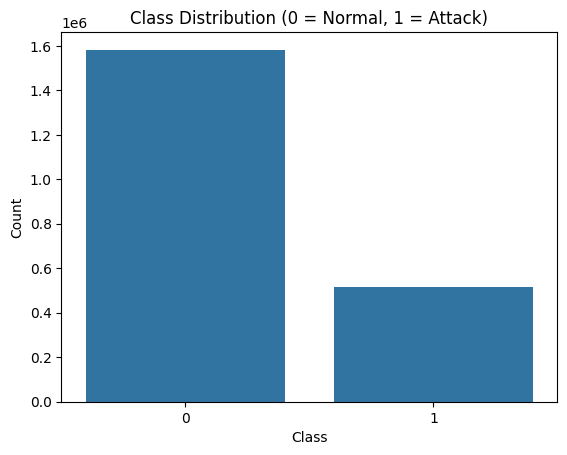

In [70]:
#class distribution
plt.figure()
sns.countplot(x=y)
plt.title("Class Distribution (0 = Normal, 1 = Attack)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
     Data Cleaning
    </span>
</div>

In [71]:
# Cleaning data
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

<div style="text-align: center; margin: 25px 0;">
    <span style="
        font-size: 36px;
        font-weight: 700;
        font-family: 'Segoe UI', 'Calibri', sans-serif;
        color: #66b3ff;
        -webkit-text-stroke: 2px #002b5c;
    ">
     Data Mining
    </span>
</div>

In [72]:
#  Removing duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()

#  Removing constant / near-constant features
nunique = df.nunique()
constant_features = nunique[nunique <= 1].index
df = df.drop(columns=constant_features)

print("Removed constant features:", list(constant_features))

#  Removing highly correlated features (>0.95)
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = [
    column for column in upper.columns if any(upper[column] > 0.95)
]

df = df.drop(columns=high_corr_features, errors="ignore")

print("Removed highly correlated features:", len(high_corr_features))



Duplicates before: 3167
Removed constant features: []
Removed highly correlated features: 27


In [73]:
# Converted labels to binary
df["Label"] = df["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

In [74]:
# Separating features and target
y = df["Label"]
X = df.drop("Label", axis=1)

# Keeping numeric features only
X = X.select_dtypes(include=[np.number])


In [109]:

# TIME-BASED SPLIT (NO LEAKAGE)


# Keeping original order 
df = df.reset_index(drop=True)

# Recreating X and y after cleaning
y = df["Label"]
X = df.drop("Label", axis=1)
X = X.select_dtypes(include=[np.number])

# 70% past data → train, 30% future data → test
split_index = int(len(df) * 0.7)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 1467762
Test size: 629042


In [110]:
#Feature Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [111]:
# Isolation Forest
X_train_normal = X_train_scaled[y_train == 0]
attack_ratio = y_train.mean()

iso = IsolationForest(
    contamination=attack_ratio,
    random_state=42
)

iso.fit(X_train_normal)
iso_pred = iso.predict(X_test_scaled)

# Convert (-1,1) → (1,0)
iso_pred = np.where(iso_pred == -1, 1, 0)

print("\n=== Isolation Forest ===")
print(confusion_matrix(y_test, iso_pred))
print(classification_report(y_test, iso_pred))
print("ROC-AUC:", roc_auc_score(y_test, iso_pred))



=== Isolation Forest ===
[[346254 100939]
 [  1851 179998]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87    447193
           1       0.64      0.99      0.78    181849

    accuracy                           0.84    629042
   macro avg       0.82      0.88      0.82    629042
weighted avg       0.89      0.84      0.84    629042

ROC-AUC: 0.8820521823984458


In [112]:
# Random Forest 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,        # limit tree depth
    min_samples_leaf=10, # prevent memorization
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

rf_prob = rf.predict_proba(X_test_scaled)[:, 1]
rf_pred = rf.predict(X_test_scaled)   

print("\n=== Random Forest (Class Weight) ===") 
print(confusion_matrix(y_test, rf_pred)) 
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))



=== Random Forest (Class Weight) ===
[[447157     36]
 [ 24497 157352]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    447193
           1       1.00      0.87      0.93    181849

    accuracy                           0.96    629042
   macro avg       0.97      0.93      0.95    629042
weighted avg       0.96      0.96      0.96    629042

ROC-AUC: 0.9999374952778974


In [114]:
# Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

print("\n=== Logistic Regression (Class Weight) ===")
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_pred))


=== Logistic Regression (Class Weight) ===
[[446129   1064]
 [ 73677 108172]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92    447193
           1       0.99      0.59      0.74    181849

    accuracy                           0.88    629042
   macro avg       0.92      0.80      0.83    629042
weighted avg       0.90      0.88      0.87    629042

ROC-AUC: 0.7962329439209423


In [115]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 15 Important Features:")
print(feature_importance.head(15))


Top 15 Important Features:
                       Feature  Importance
8        Fwd Packet Length Max    0.165185
7   Total Length of Fwd Packet    0.140396
10      Fwd Packet Length Mean    0.098268
0                   Src IP dec    0.082811
35              SYN Flag Count    0.044000
47          FWD Init Win Bytes    0.040679
2                   Dst IP dec    0.038162
11       Fwd Packet Length Std    0.033003
33           Packet Length Min    0.030885
36              RST Flag Count    0.028515
12       Bwd Packet Length Max    0.028074
4                     Protocol    0.024396
9        Fwd Packet Length Min    0.021911
13       Bwd Packet Length Min    0.018081
24               Fwd PSH Flags    0.016858


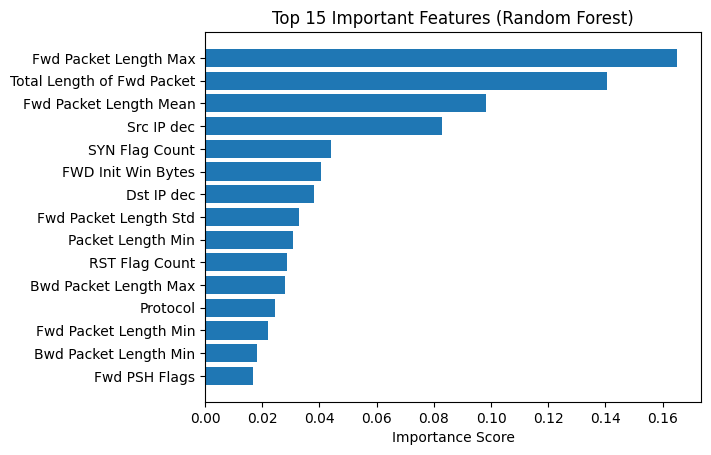

In [85]:
#feature importance
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure()
plt.barh(feature_importance_df["Feature"][:15],
         feature_importance_df["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

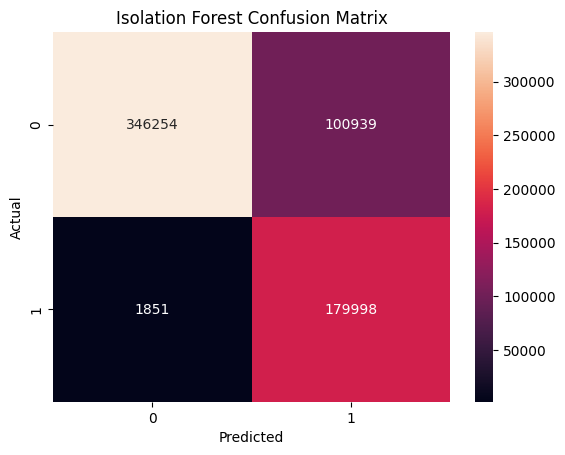

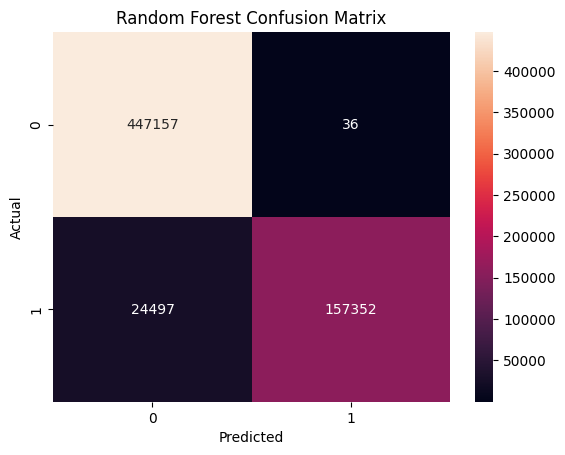

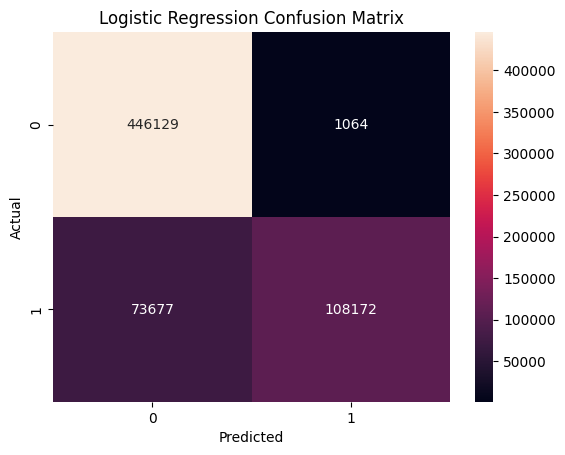

In [116]:
#confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, iso_pred, "Isolation Forest Confusion Matrix")
plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, lr_pred, "Logistic Regression Confusion Matrix")

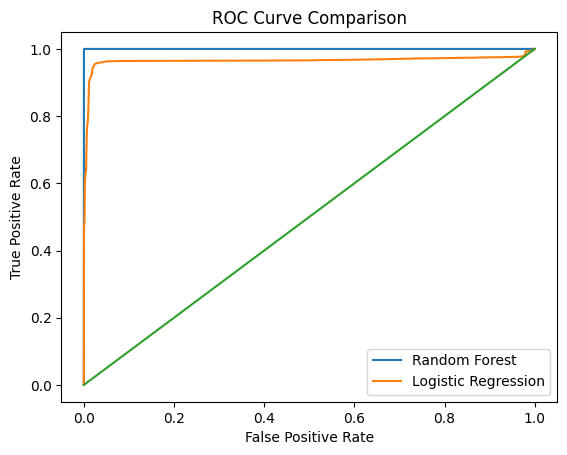

In [83]:
#Roc Curve comparision
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])

plt.figure()
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot([0,1], [0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

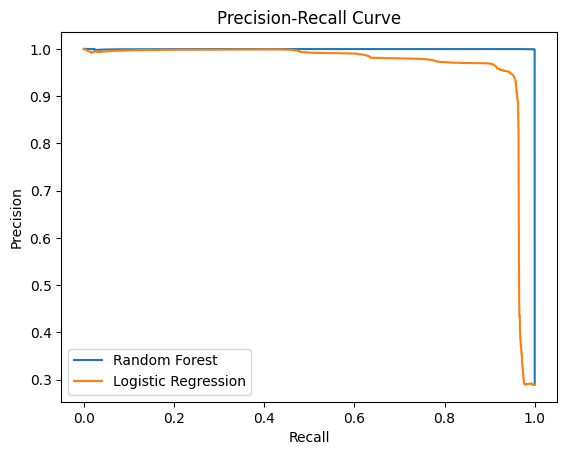

In [84]:
#precision recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob)
precision_lr, recall_lr, _ = precision_recall_curve(
    y_test, lr.predict_proba(X_test_scaled)[:,1]
)

plt.figure()
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [88]:
# Creating a table with model performance metrics
metrics_table = pd.DataFrame({ "Model": ["IsolationForest", "RandomForest", "LogisticRegression"], 
                              "Precision": [ classification_report(y_test, iso_pred, output_dict=True)["1"]["precision"], 
                                            classification_report(y_test, rf_pred, output_dict=True)["1"]["precision"], 
                                            classification_report(y_test, lr_pred, output_dict=True)["1"]["precision"], ],
                              "Recall": [ classification_report(y_test, iso_pred, output_dict=True)["1"]["recall"],
                                         classification_report(y_test, rf_pred, output_dict=True)["1"]["recall"], 
                                         classification_report(y_test, lr_pred, output_dict=True)["1"]["recall"], ], 
                              "F1-Score": [ classification_report(y_test, iso_pred, output_dict=True)["1"]["f1-score"],
                                           classification_report(y_test, rf_pred, output_dict=True)["1"]["f1-score"], 
                                           classification_report(y_test, lr_pred, output_dict=True)["1"]["f1-score"], ],
                              "ROC-AUC": [ roc_auc_score(y_test, iso_pred),
                                          roc_auc_score(y_test, rf_pred), 
                                          roc_auc_score(y_test, lr_pred), ] 
                             })

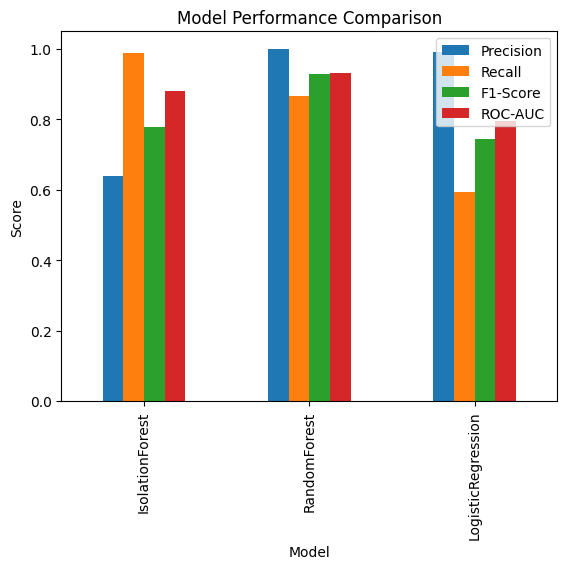

In [89]:
#model performance comparision bar chart
metrics_table.set_index("Model")[["Precision","Recall","F1-Score","ROC-AUC"]].plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()